### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from sklearn import cluster
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
import pickle

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")



### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="2.1"></a>

In [2]:
path = '../input/brain-tumor-classification-mri-images/brain_tumor_mri/new_dataset/'
print(os.listdir(path))

['labels.pickle', 'training_data.pickle', 'bt_images']


In [3]:
training_data = pickle.load(open(path+'training_data.pickle','rb'))
random.shuffle(training_data)

In [4]:
total_data_len = len(training_data)
classes = ['Meningioma', 'Glioma', 'Pitutary']
n_classes = len(classes)

x_raw = []
y_raw = []

for i in training_data:
    x_raw.append(i[0])
    y_raw.append(i[1])

y_raw = list(np.asarray(y_raw)-np.ones(total_data_len,dtype=np.int))

#### 2.Observing the  Dataset<a class="anchor" id="2.2"></a>

In [5]:
print(f'Total number of images : {total_data_len}')

Total number of images : 3064


Pitutary


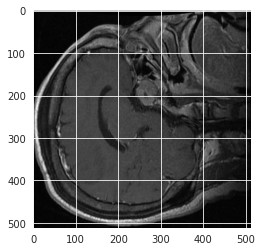

In [6]:
plt.imshow(x_raw[0])
print(classes[y_raw[0]])

Number of scans with Meningioma : 708 Glioma : 1426 Pitutary : 930


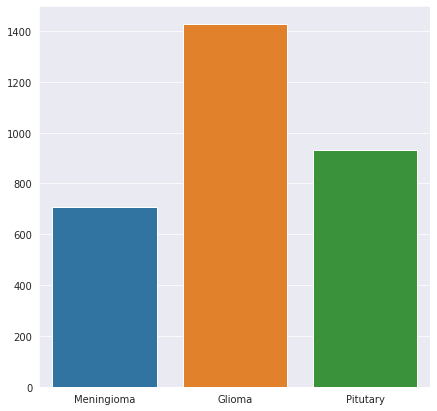

In [7]:
each_class = [0,0,0]
for i in y_raw:
    for j in range(n_classes):
        if i == j:
            each_class[j] = each_class[j] + 1
print(f'Number of scans with Meningioma : {each_class[0]} Glioma : {each_class[1]} Pitutary : {each_class[2]}')            
ax, fig = plt.subplots(figsize=[7,7])
sns.barplot(x=classes, y=each_class)
plt.show()

In [8]:
sample = []
sample_size = 4
for i in range(n_classes):
    temp = []
    key = 0
    while True:
        index = y_raw.index(i,key,total_data_len-1)
        key = index+1
        temp.append(x_raw[index])
        
        if len(temp) == sample_size:
            break
            
    sample.append(temp)
sample = np.asarray(sample)
print(f'sample contains {len(sample)} classes with {len(sample[0])} samples in each class')

sample contains 3 classes with 4 samples in each class


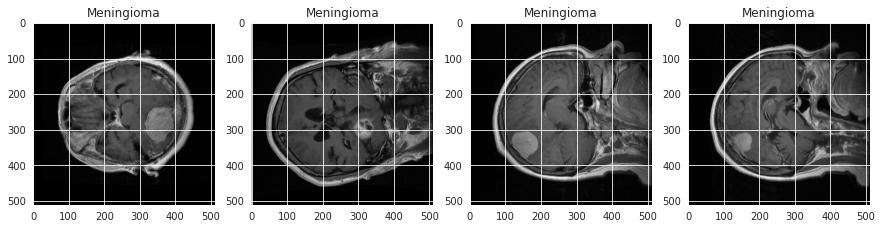

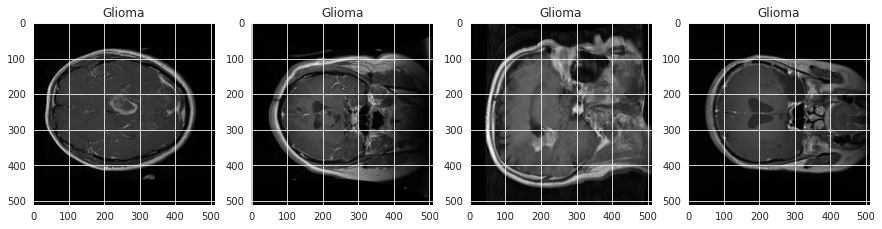

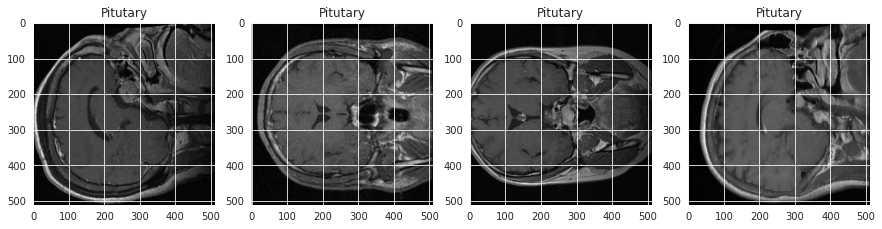

In [9]:
for i in range(n_classes):
    fig = plt.figure(figsize=(15,15))
    for j in range(sample_size):
        fig.add_subplot(i+1,sample_size ,j+1)
        plt.title(classes[i])
        plt.imshow(sample[i][j])


In [10]:
def clustered_img(x):
    kmeans = cluster.KMeans(5)
    dims = np.shape(x)
    pixel_matrix = np.reshape(x, (dims[0] * dims[1], dims[2]))
    clustered = kmeans.fit_predict(pixel_matrix)


    clustered_img = np.reshape(clustered, (dims[0], dims[1]))
    return clustered_img

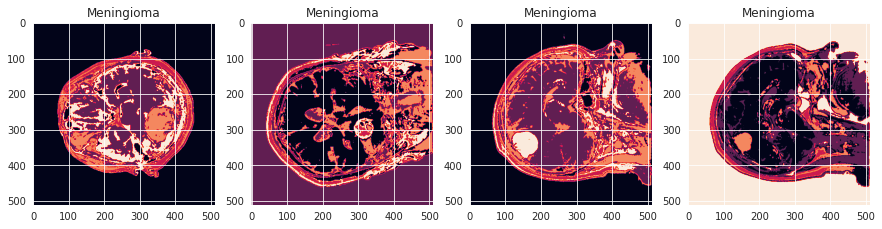

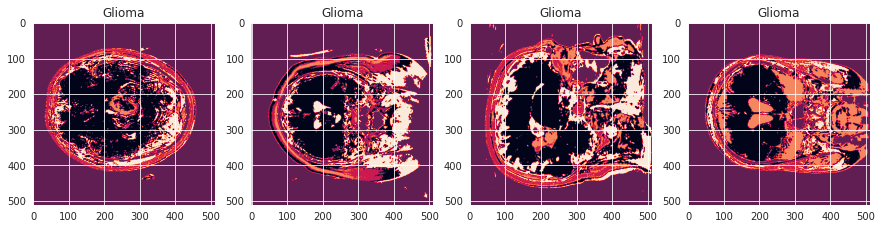

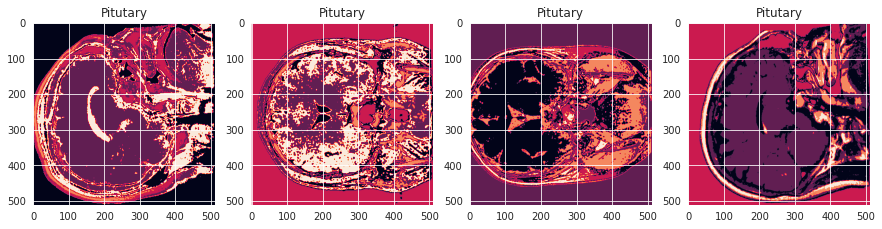

In [11]:
for i in range(n_classes):
    fig = plt.figure(figsize=(15,15))
    for j in range(sample_size):
        fig.add_subplot(i+1,sample_size ,j+1)
        plt.title(classes[i])
        plt.imshow(clustered_img(sample[i][j]))


#### 3.Splitting Dataset <a class="anchor" id="2.3"></a>

In [12]:
n_train = int(0.95 *total_data_len)
n_validation = int(0.021*total_data_len)

train_image = x_raw[:n_train]
train_label = y_raw[:n_train]

validation_image = x_raw[n_train:n_train+n_validation]
validation_label = y_raw[n_train:n_train+n_validation]

test_image = x_raw[n_train:n_train+n_validation:]
test_label = y_raw[n_train:n_train+n_validation:]

#### 4.Pytorch DataLoaders <a class="anchor" id="2.4"></a>

In [13]:
class Dataset(Dataset):
    def __init__(self,x,y,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.y = y 
        self.len = len(x)
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        return torch.FloatTensor(np.asarray(self.transform(Image.fromarray(self.x[i])))),torch.LongTensor([self.y[i]])

batch_size = 16

transforms_train = T.Compose([
        T.Resize((224,224)),
        T.RandomRotation(degrees=(-45, 45)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = Dataset(train_image,train_label,transform =transforms_train)
validation_dataset = Dataset(validation_image,validation_label,transform =transforms_test)
test_dataset = Dataset(test_image,test_label,transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = True )

In [14]:
next(iter(train_dataloader))[0].shape

torch.Size([16, 3, 224, 224])

### 3.Initialize the pre-trained model <a class="anchor" id="3"></a>

In [15]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

### 4.Training of Model <a class="anchor" id="4"></a>

In [16]:
lr = 0.0015
epoch = 15
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

device = 'cuda'
model.to(device)
loss_history = [[],[]] #[[train], [validation]]
accuracy_history = [[],[]] #[[train], [validation]]

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(),lr = lr)



In [17]:
for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    for batch_idx , (x ,y) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y = x.to(device) , y.to(device)
        y_pred = model(x).to(device)
        
        # Calculating Loss
        loss = criterion(y_pred,y.reshape(x.shape[0]))
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = y.cpu().detach().numpy().tolist()
        for i in range(x.shape[0]):
            n = 0
            n = y_pred[i].index(max(y_pred[i]))
            if n == y[i][0]:
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
        if batch_idx % 30 == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            print(f'TRAIN ACCURACY : {accuracy_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (x ,y) in enumerate(validation_dataloader):
                    x , y = x.to(device) , y.to(device)
                    y_pred = model(x).to(device)
                    validation_loss = criterion(y_pred,y.reshape(x.shape[0]))
                    loss_history[1].append(float(validation_loss.detach()))
                    
                    correct = 0
                    y_pred = y_pred.cpu().detach().numpy().tolist()
                    y = y.cpu().detach().numpy().tolist()      
                    for i in range(x.shape[0]):
                        n = 0
                        n = y_pred[i].index(max(y_pred[i]))
                        if n == y[i][0]:
                            correct = correct + 1
                    accuracy_history[1].append((correct/x.shape[0])*100)
                        
                    
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = ' ')
                print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')
    
    # Saving the model progress
    torch.save(model.state_dict(),'resnet50_v1')
    
    #Log for e+1th epoch
    print(f'--------------------------------------------------------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    print(f'TRAIN ACCURACY : {sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    n_validation_losses = int(train_n_minibatches/30)*validation_n_minibatches
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}',end = ' ')
    print(f'VALIDATION ACCURACY : {sum(accuracy_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
LOSS for EPOCH 1 BATCH 0/182 TRAIN LOSS : 1.1408262252807617 TRAIN ACCURACY : 18.75 VALIDATION LOSS : 1.0617323219776154 VALIDATION ACCURACY : 53.125
LOSS for EPOCH 1 BATCH 30/182 TRAIN LOSS : 0.8990775942802429 TRAIN ACCURACY : 75.0 VALIDATION LOSS : 0.9278904795646667 VALIDATION ACCURACY : 53.125
LOSS for EPOCH 1 BATCH 60/182 TRAIN LOSS : 0.8407142758369446 TRAIN ACCURACY : 68.75 VALIDATION LOSS : 0.8674703389406204 VALIDATION ACCURACY : 67.1875
LOSS for EPOCH 1 BATCH 90/182 TRAIN LOSS : 0.7941499352455139 TRAIN ACCURACY : 68.75 VALIDATION LOSS : 0.8075233399868011 VALIDATION ACCURACY : 67.1875
LOSS for EPOCH 1 BATCH 120/182 TRAIN LOSS : 0.6728276610374451 TRAIN ACCURACY : 75.0 VALIDATION LOSS : 0.7183193266391754 VALIDATION ACCURACY : 78.125
LOSS for EPOCH 1 BATCH 150/182 TRAIN LOSS : 0.5336748361587524 TRAIN ACCURACY : 87.5 VALIDATION LOSS : 0.6369037479162216 VALIDATION ACCURACY : 79.6875
LOS

### 5.Plotting Graphs<a class="anchor" id="5"></a>

In [18]:
avg_loss_history = [[],[]]
avg_accuracy_history = [[],[]]

for i in range(0,len(loss_history[0]),30):
    avg_loss_history[0].append(sum(loss_history[0][i:i+30])/30)
    
for i in range(0,len(loss_history[1]),4):
    avg_loss_history[1].append(sum(loss_history[1][i:i+4])/4)
    
for i in range(0,len(accuracy_history[0]),30):
    avg_accuracy_history[0].append(sum(accuracy_history[0][i:i+30])/30)
    
for i in range(0,len(accuracy_history[1]),4):
    avg_accuracy_history[1].append(sum(accuracy_history[1][i:i+4])/4)



#### 1.Plotting Loss vs MiniBatch<a class="anchor" id="5.1"></a>

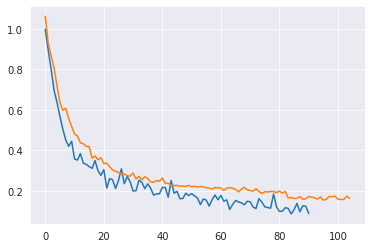

In [19]:
sns.lineplot(x=range(len(avg_loss_history[0])),y=avg_loss_history[0])
sns.lineplot(x=range(len(avg_loss_history[1])),y=avg_loss_history[1])
plt.show()


#### 2.Plotting Accuracy Graph<a class="anchor" id="5.2"></a>

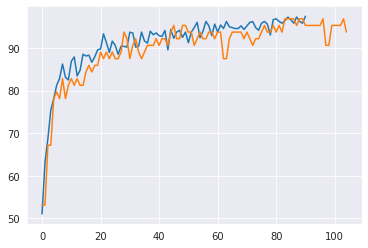

In [20]:
sns.lineplot(x=range(len(avg_accuracy_history[0])),y=avg_accuracy_history[0])
sns.lineplot(x=range(len(avg_accuracy_history[1])),y=avg_accuracy_history[1])
plt.show()

#### 3.Plotting Loss vs Epoch<a class="anchor" id="5.3"></a>

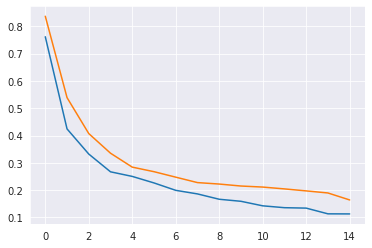

In [21]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(x=range(len(loss_per_epoch[0])),y=loss_per_epoch[0])
sns.lineplot(x=range(len(loss_per_epoch[1])),y=loss_per_epoch[1])
plt.show()

#### 4.Plotting Accuracy vs Epoch<a class="anchor" id="5.4"></a>

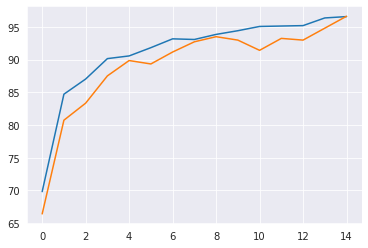

In [22]:
# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in accuracy_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in accuracy_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(x=range(len(accuracy_per_epoch[0])),y=accuracy_per_epoch[0])
sns.lineplot(x=range(len(accuracy_per_epoch[1])),y=accuracy_per_epoch[1])
plt.show()

### 6.Loading and Testing<a class="anchor" id="6"></a>

In [23]:
test_loss_history = []
test_accuracy_history = []

In [24]:
#Testing the model on test dataset
model = model.to('cpu')
model.eval()
for _batch_idx_ , (x ,y) in enumerate(test_dataloader):
    y_pred = model(x)
    test_loss = criterion(y_pred,y.reshape(x.shape[0]))
    test_loss_history.append(float(test_loss.detach()))
    correct = 0
    y_pred = y_pred.detach().numpy().tolist()
    y = y.detach().numpy().tolist()      
    for i in range(x.shape[0]):
        n = 0
        n = y_pred[i].index(max(y_pred[i]))
        if n == y[i][0]:
            correct = correct + 1
    test_accuracy_history.append((correct/len(y))*100)
                        
print(f'LOSS : {sum(test_loss_history)/len(test_loss_history)}  ACCURACY : {sum(test_accuracy_history)/len(test_accuracy_history)}')                    

LOSS : 0.15091711096465588  ACCURACY : 95.3125
